In [1]:
import random
from itertools import chain

import msprime
import pyslim
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import SVG

Load the `trees` file generated by SLiM and inspect the contents:

In [2]:
slim_ts = pyslim.load("results/europe_tree_seq.trees")

In [3]:
slim_ts

Check that all trees in the sequence are coalesced:

In [4]:
def check_coalescence(ts):
    """Check whether all trees in a sequence completely coalesced."""
    for t in ts.trees():
         assert t.num_roots == 1, ("not coalesced! on segment {} to {}".
              format(t.interval[0], t.interval[1]))

In [5]:
check_coalescence(slim_ts)

## Simplification

Realistically, we will never have all data that we simulated, which is why we subsample to _N_ chromosomes from each population and then simplify the tree sequence coalescent structure accordingly.

In [6]:
# subsample to 1 chromosome from each population
k = 1
samples = []

for pop in slim_ts.populations():
    pop_sample = random.sample(list(slim_ts.samples(pop.id)), k=k)
    samples.append(pop_sample)

# flatten the lists
samples = list(chain.from_iterable(samples))

In [7]:
ts, mapping = slim_ts.simplify(samples=samples, map_nodes=True)

## Plot the first tree

In [8]:
tree = ts.first()

Put together a table of population ➡ color assignments for coloring the nodes of the tree:

In [9]:
color_map = {0: "red", 1: "blue", 2: "green", 3: "brown", 4: "orange", 5: "purple", 6: "black"}

In [10]:
pop_names = open("model-europe/names.txt").read().splitlines()

In [11]:
pop_colors = pd.DataFrame.from_dict(color_map, orient="index")
pop_colors["pop"] = pop_names
pop_colors

,0,pop
0,red,AFR
1,blue,OOA
2,green,EHG
3,brown,ANA
4,orange,EUR
5,purple,YAM
6,black,YAM_migr


Assign color to each node:

In [12]:
node_colors = {i: color_map[tree.population(i)] for i in tree.nodes()}

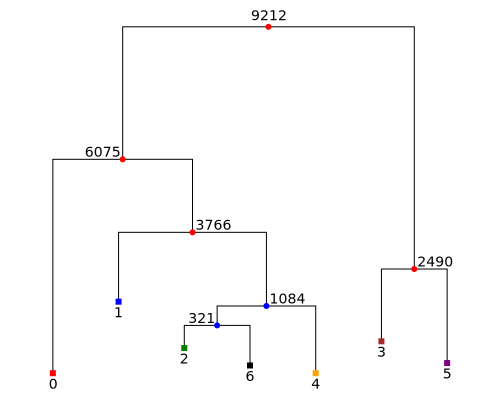

In [13]:
SVG(tree.draw(width=500, height=400, node_colours=node_colors))

## Add mutations to the trees

I just ran [this](https://pyslim.readthedocs.io/en/latest/tutorial.html#adding-neutral-mutations-to-a-slim-simulation) but did not investigate further.

In [14]:
ts = pyslim.SlimTreeSequence(msprime.mutate(ts, rate=1e-8, keep=True))

print(f"The tree sequence now has {ts.num_mutations} mutations")

The tree sequence now has 46738 mutations


In [15]:
genotypes = ts.genotype_matrix()

In [16]:
genotypes.shape

(46738, 7)

We generated genotypes of 7 chromosomes as we wanted...

In [17]:
genotypes

array([[0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 1, 0, 0],
       ...,
       [0, 1, 1, ..., 1, 1, 1],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]], dtype=int8)

## Locations of owners of those sampled chromosomes

In [18]:
ts.individual_locations.shape

(7, 3)

In [19]:
ts.individual_locations

array([[3.33997965e+002, 4.40256422e+001, 0.00000000e+000],
       [2.33445346e+002, 2.94061084e+002, 1.42173718e-311],
       [6.85491679e+002, 1.92478123e+002, 7.72521670e+007],
       [4.71898318e+002, 2.15655492e+002, 1.00000000e+000],
       [4.17080406e+002, 4.43362408e+002, 7.17234590e-312],
       [4.90827829e+002, 3.47596402e+002, 6.01814120e+007],
       [4.31505486e+002, 3.25657641e+002, 6.91469389e+001]])

So each individual has a location attached to it in three-dimensions, but the third one is "basically zero" (which makes sense, because we run the SLiM simulation on a two-dimensional map).

The metadata of each individual (most importantly the time and location) can be accessed via tskit/pyslim API:

In [20]:
ts.individual(0)

{'id': 0, 'flags': 65536, 'location': array([333.99796546,  44.02564225,   0.        ]), 'parents': array([], dtype=int32), 'nodes': array([0], dtype=int32), 'population': 0, 'time': 0.0, 'metadata': {'pedigree_id': 873019302, 'age': -1, 'subpopulation': 0, 'sex': -1, 'flags': 0}}

The simplest thing to start with would be generating genotype data with msprime (as shown above and in the documentation) and then extract the true known locations of individuals using the tskit functionality.